<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB
None


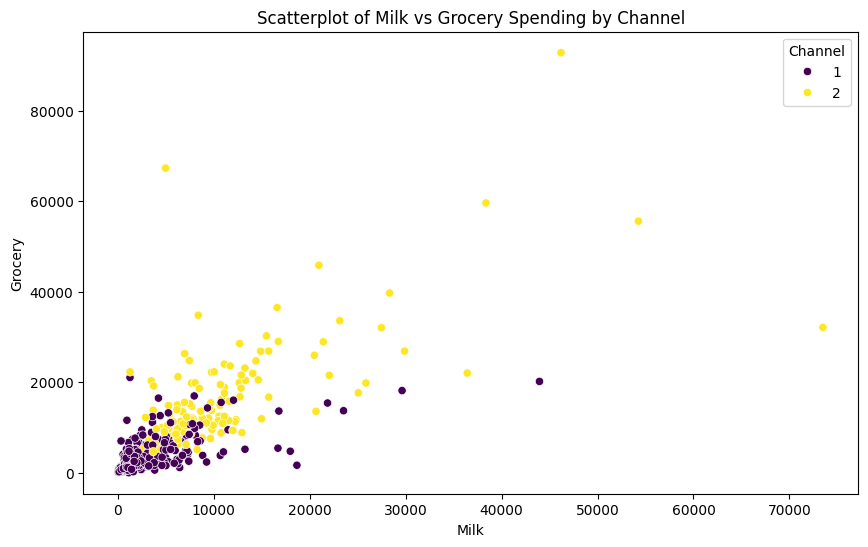

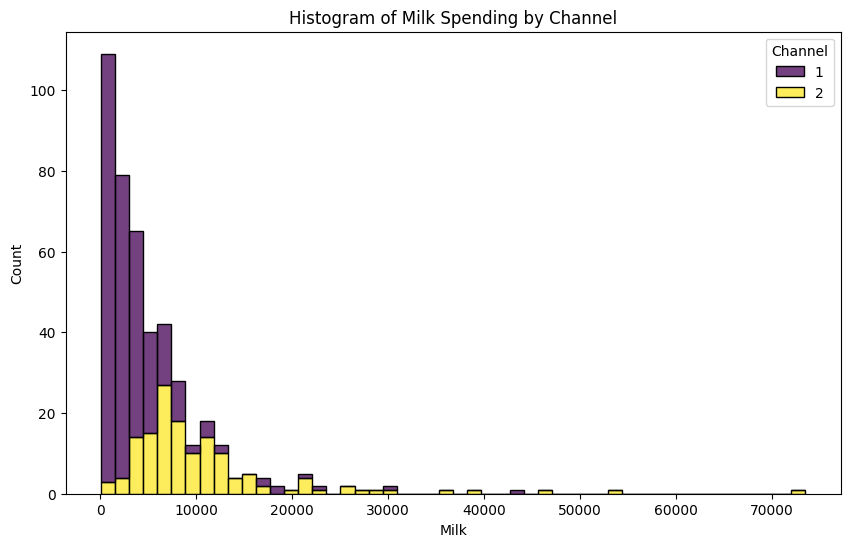

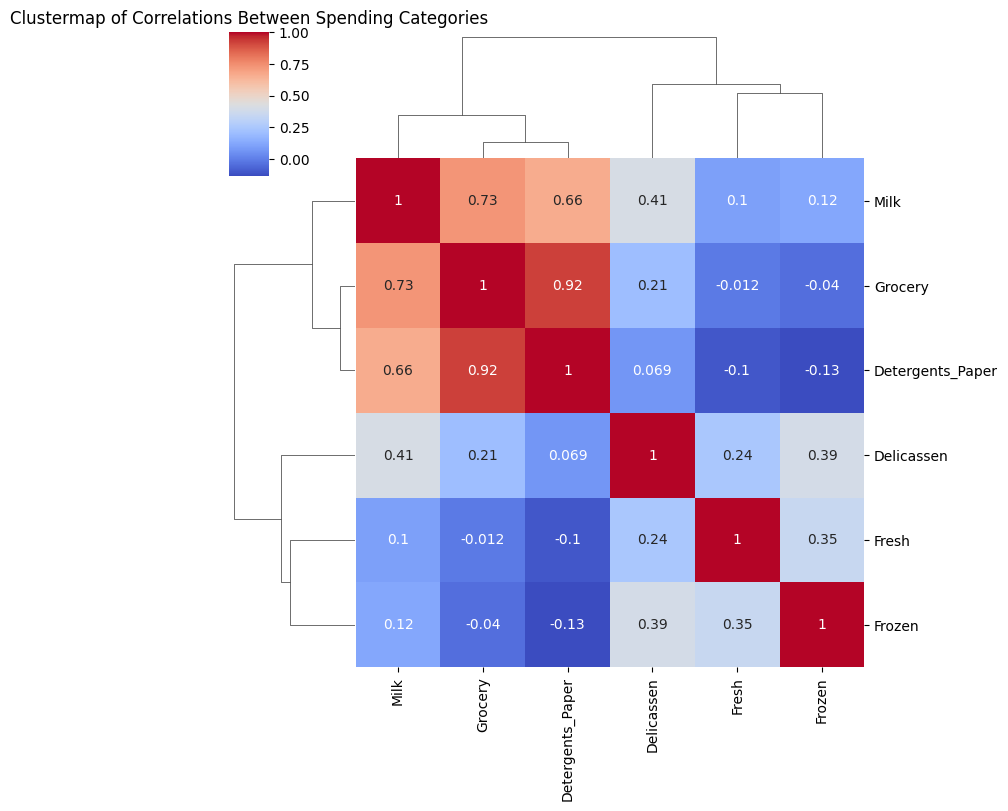

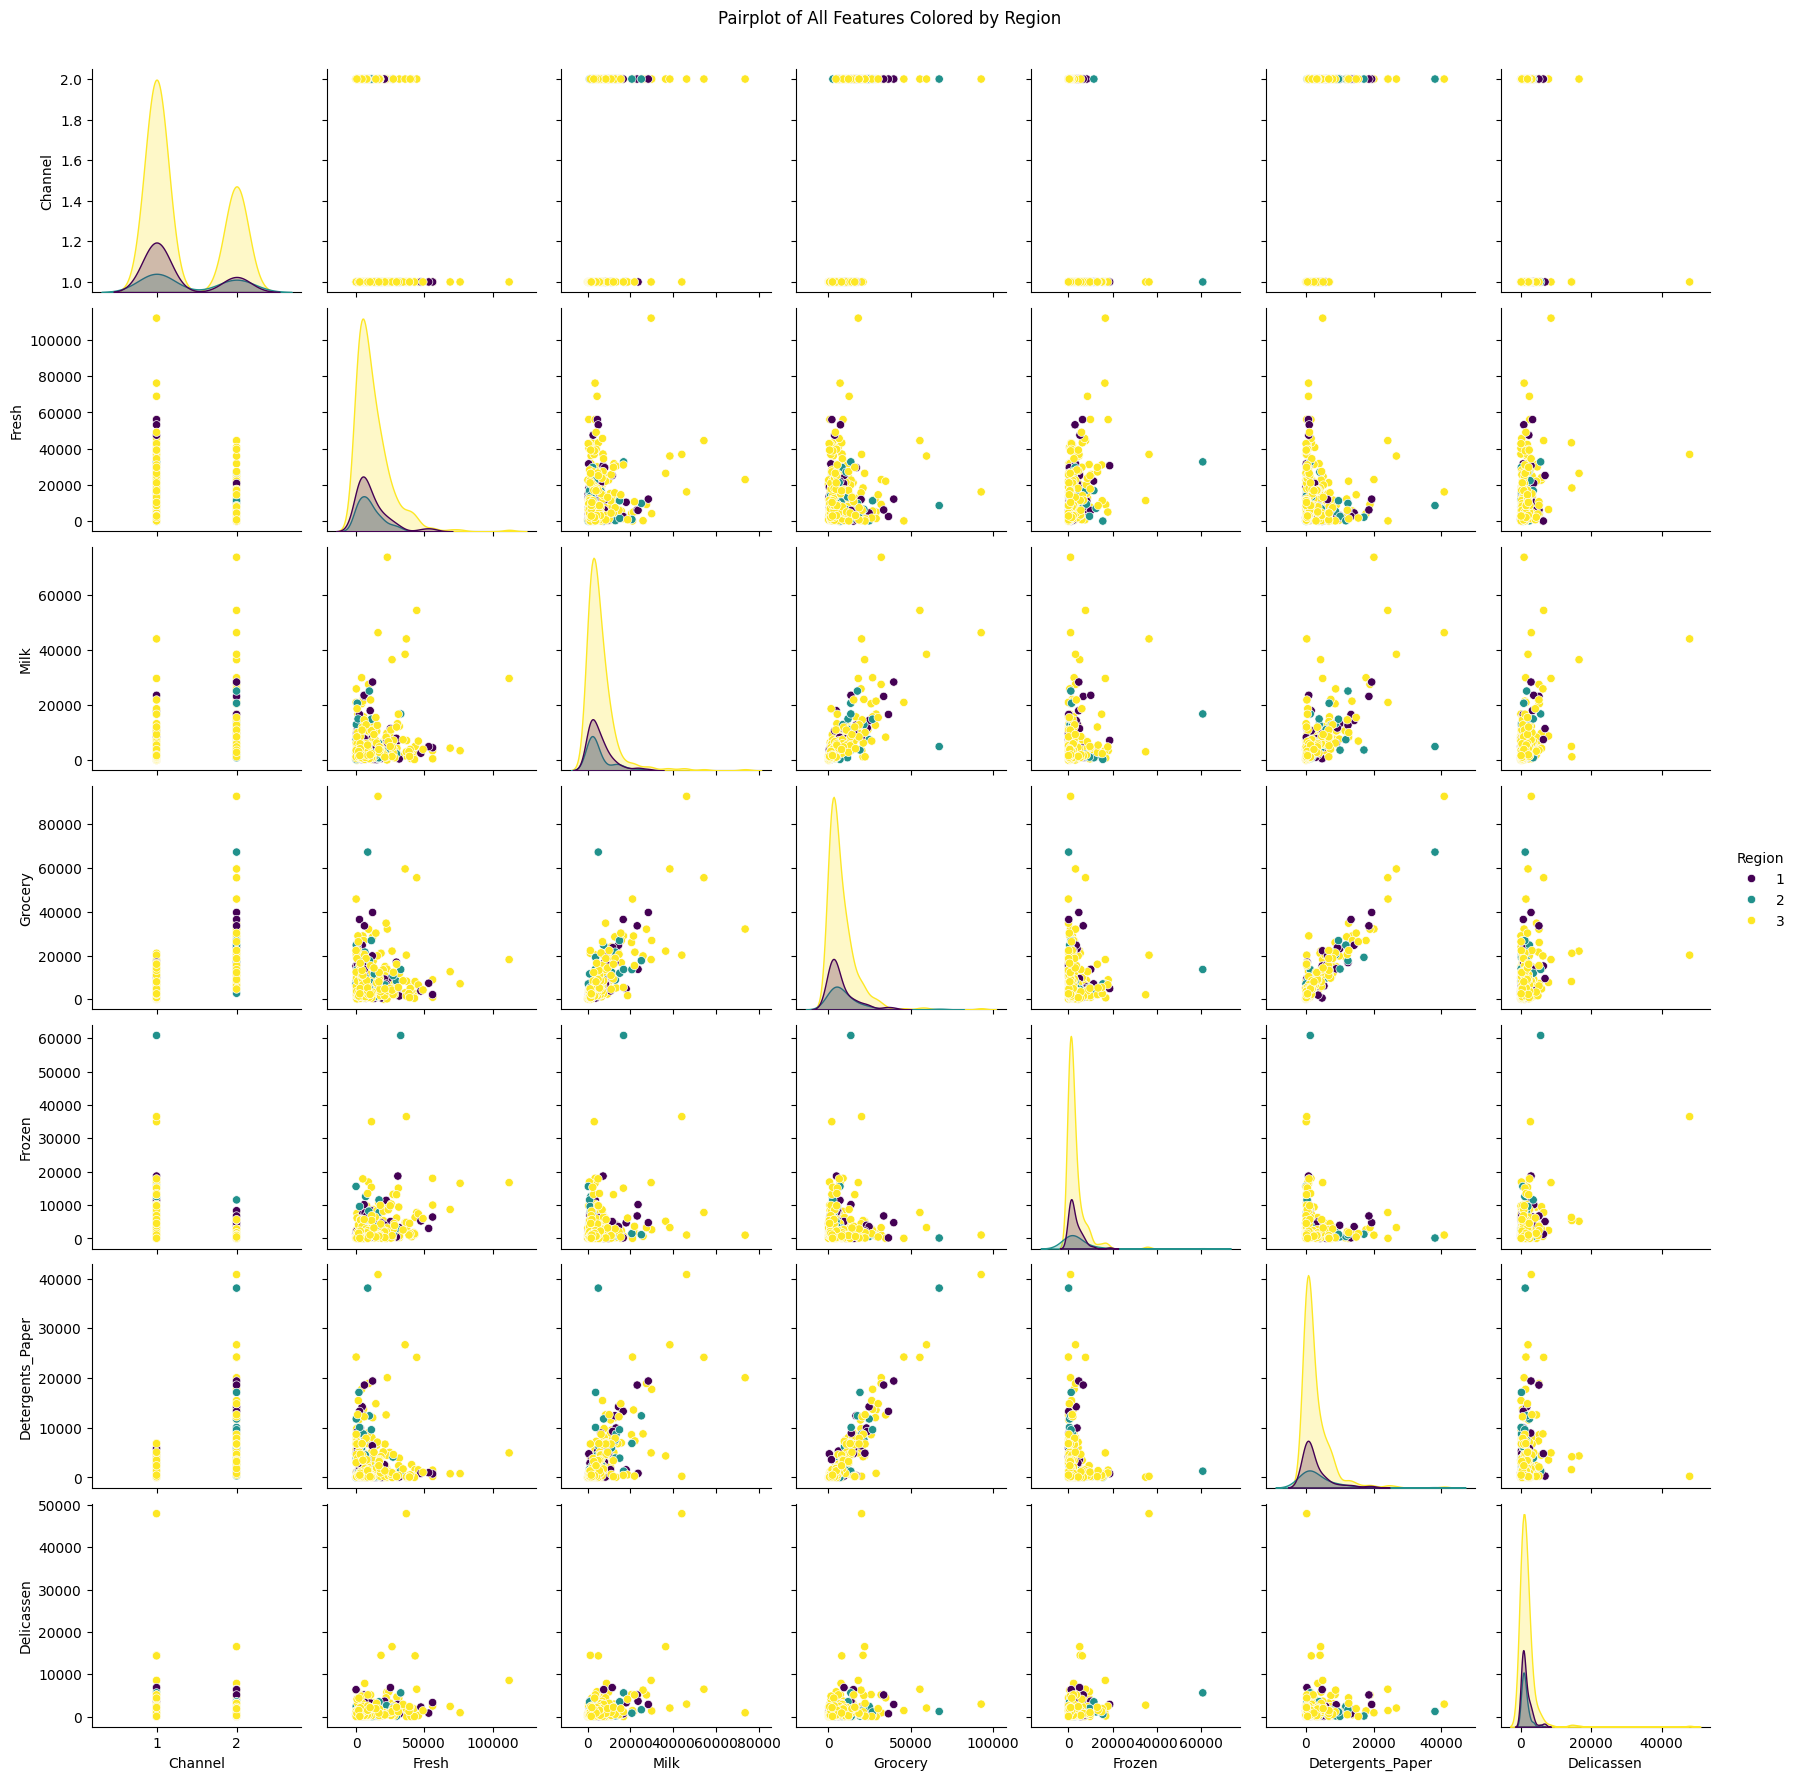

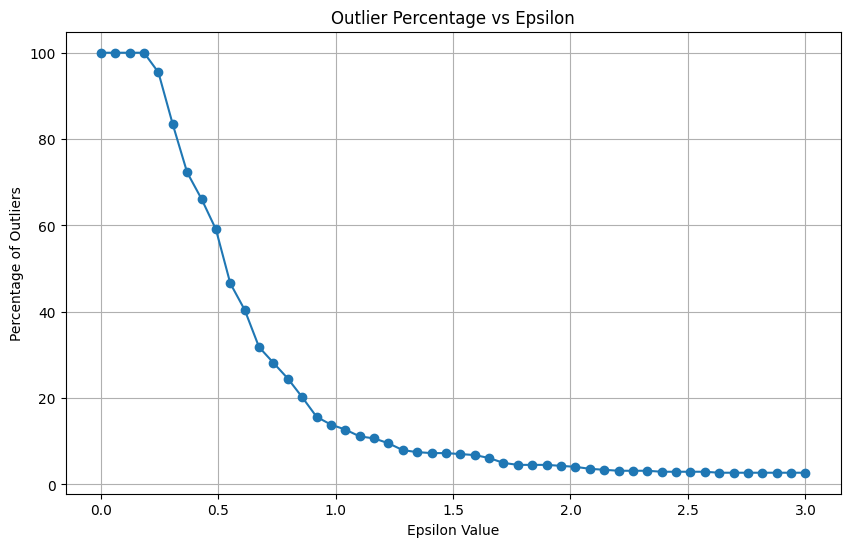

Calculated epsilon: 1.830


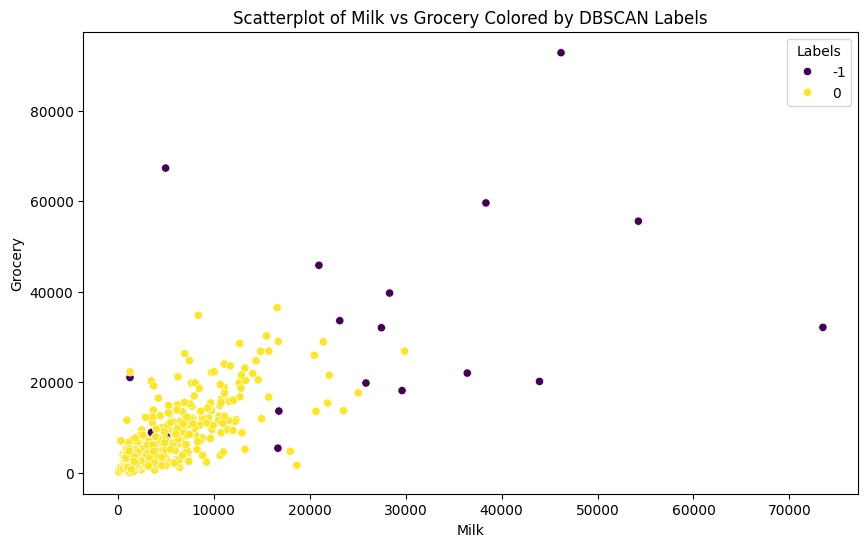

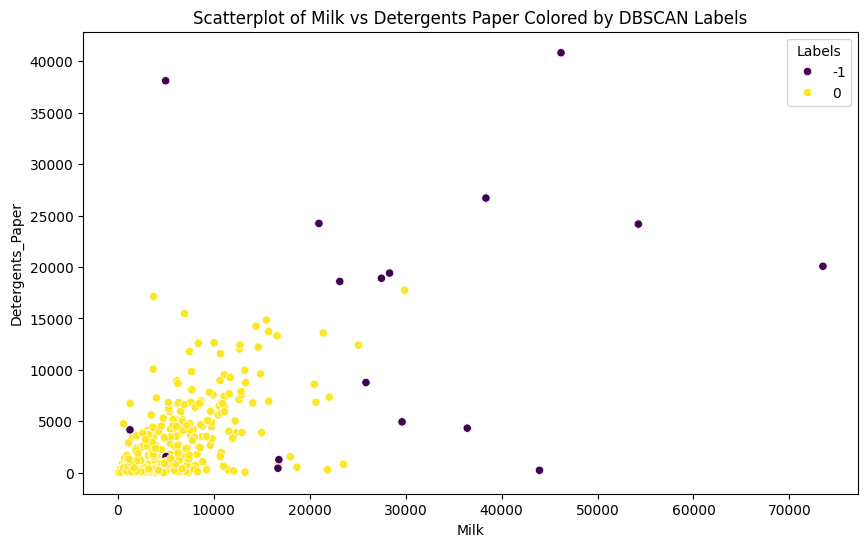

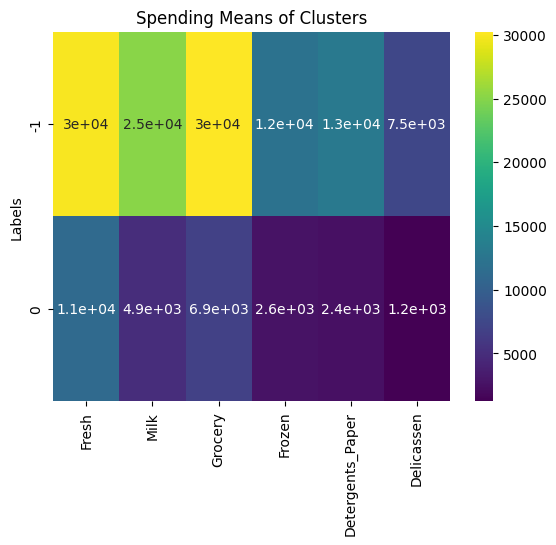

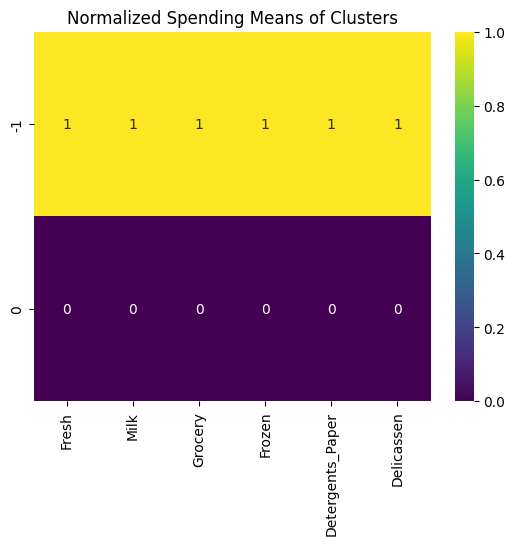

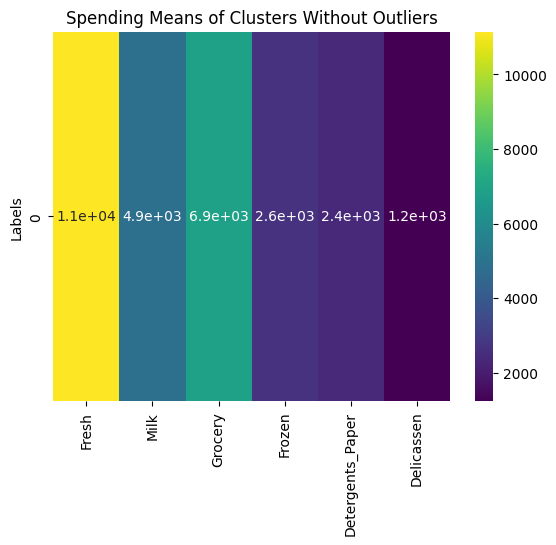

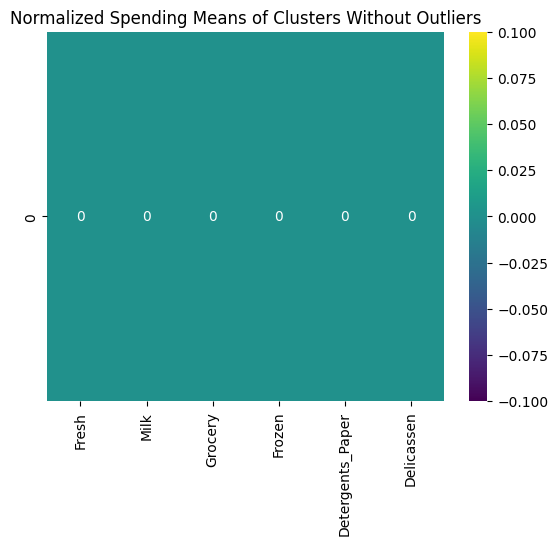

The spending category with the most difference between the two clusters is: Grocery


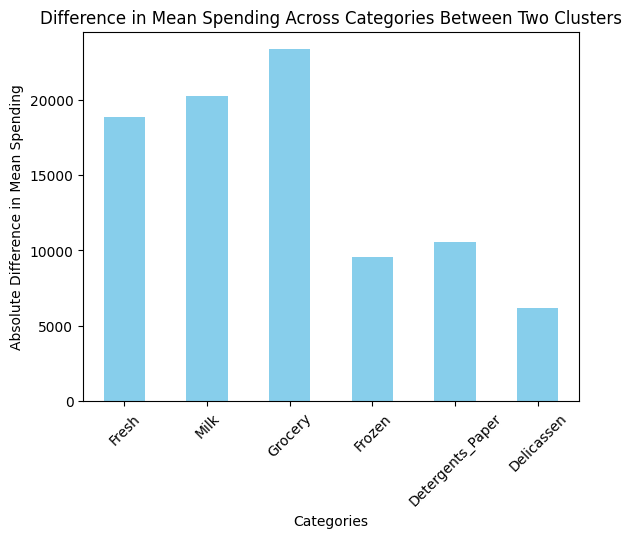

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import warnings

warnings.filterwarnings('ignore')

def load_and_inspect_data(filepath):
    data = pd.read_csv(filepath)
    print(data.info())
    return data

def plot_scatterplot(data):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=data, x='Milk', y='Grocery', hue='Channel', palette='viridis')
    plt.title('Scatterplot of Milk vs Grocery Spending by Channel')
    plt.show()

def plot_histogram(data):
    plt.figure(figsize=(10, 6))
    sns.histplot(data=data, x='Milk', hue='Channel', multiple='stack', palette='viridis')
    plt.title('Histogram of Milk Spending by Channel')
    plt.show()

def plot_clustermap(data):
    corr = data[['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']].corr()
    sns.clustermap(corr, annot=True, cmap='coolwarm', figsize=(8, 8))
    plt.title('Clustermap of Correlations Between Spending Categories')
    plt.show()

def plot_pairplot(data):
    sns.pairplot(data, hue='Region', palette='viridis')
    plt.suptitle('Pairplot of All Features Colored by Region', y=1.02)
    plt.show()

def scale_data(data):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data[['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']])
    scaled_df = pd.DataFrame(scaled_data, columns=['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen'])
    return scaled_df

def plot_outliers_vs_epsilon(scaled_df):
    epsilon_values = np.linspace(0.001, 3, 50)
    outliers_percentage = []

    for eps in epsilon_values:
        dbscan = DBSCAN(eps=eps, min_samples=2 * len(scaled_df.columns))
        labels = dbscan.fit_predict(scaled_df)
        outliers_percentage.append(np.sum(labels == -1) / len(labels) * 100)

    plt.figure(figsize=(10, 6))
    plt.plot(epsilon_values, outliers_percentage, marker='o')
    plt.title('Outlier Percentage vs Epsilon')
    plt.xlabel('Epsilon Value')
    plt.ylabel('Percentage of Outliers')
    plt.grid(True)
    plt.show()

def calculate_epsilon(scaled_df):
    k = 4
    neighbors = NearestNeighbors(n_neighbors=k)
    neighbors_fit = neighbors.fit(scaled_df)
    distances, indices = neighbors_fit.kneighbors(scaled_df)
    kth_distances = distances[:, k-1]
    mean_distance = np.mean(kth_distances)
    std_distance = np.std(kth_distances)
    epsilon = mean_distance + std_distance
    print(f"Calculated epsilon: {epsilon:.3f}")
    return epsilon

def apply_dbscan(data, scaled_df, eps):
    dbscan = DBSCAN(eps=eps, min_samples=2 * len(scaled_df.columns))
    data['Labels'] = dbscan.fit_predict(scaled_df)

def plot_clusters(data):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=data, x='Milk', y='Grocery', hue='Labels', palette='viridis')
    plt.title('Scatterplot of Milk vs Grocery Colored by DBSCAN Labels')
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=data, x='Milk', y='Detergents_Paper', hue='Labels', palette='viridis')
    plt.title('Scatterplot of Milk vs Detergents Paper Colored by DBSCAN Labels')
    plt.show()

def plot_mean_spending(data):
    mean_values = data.groupby('Labels')[['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']].mean()
    sns.heatmap(mean_values, annot=True, cmap='viridis', xticklabels=mean_values.columns, yticklabels=mean_values.index)
    plt.title('Spending Means of Clusters')
    plt.show()

    scaler = MinMaxScaler()
    scaled_means = scaler.fit_transform(mean_values)
    sns.heatmap(scaled_means, annot=True, cmap='viridis', xticklabels=mean_values.columns, yticklabels=mean_values.index)
    plt.title('Normalized Spending Means of Clusters')
    plt.show()

    non_outliers = mean_values.drop(index=-1)
    sns.heatmap(non_outliers, annot=True, cmap='viridis', xticklabels=mean_values.columns, yticklabels=non_outliers.index)
    plt.title('Spending Means of Clusters Without Outliers')
    plt.show()

    scaled_means_no_outliers = scaler.transform(non_outliers)
    sns.heatmap(scaled_means_no_outliers, annot=True, cmap='viridis', xticklabels=mean_values.columns, yticklabels=non_outliers.index)
    plt.title('Normalized Spending Means of Clusters Without Outliers')
    plt.show()

    if mean_values.shape[0] > 1:
        differences = abs(mean_values.iloc[0] - mean_values.iloc[1])
        most_different_category = differences.idxmax()
        print(f"The spending category with the most difference between the two clusters is: {most_different_category}")

        differences.plot(kind='bar', color='skyblue')
        plt.title('Difference in Mean Spending Across Categories Between Two Clusters')
        plt.ylabel('Absolute Difference in Mean Spending')
        plt.xlabel('Categories')
        plt.xticks(rotation=45)
        plt.show()
    else:
        print("Not enough clusters to compare.")

def main():
    data = load_and_inspect_data('Wholesale customers data.csv')
    plot_scatterplot(data)
    plot_histogram(data)
    plot_clustermap(data)
    plot_pairplot(data)
    scaled_df = scale_data(data)
    plot_outliers_vs_epsilon(scaled_df)
    epsilon = calculate_epsilon(scaled_df)
    chosen_eps = 1.830
    apply_dbscan(data, scaled_df, chosen_eps)
    plot_clusters(data)
    plot_mean_spending(data)

if __name__ == "__main__":
    main()